# Connect to Mongo Atlas

This needs the following variables in `.env` file.  Replace `ATLAS_URI`, you can get this value from your atlas UI.


```text
ATLAS_URI=mongodb+srv://<username>:<password>@sandbox.lqlql.mongodb.net/?retryWrites=true&w=majority
DB_NAME=sample_mflix
```

References

- https://www.mongodb.com/developer/products/atlas/semantic-search-mongodb-atlas-vector-search/
- https://www.mongodb.com/languages/python/pymongo-tutorial
- https://cookbook.openai.com/examples/vector_databases/mongodb_atlas/semantic_search_using_mongodb_atlas_vector_search

In [10]:
import os, sys
import pprint
import json
import time

In [11]:
## Load Settings from .env file
from dotenv import find_dotenv, dotenv_values

# _ = load_dotenv(find_dotenv()) # read local .env file
config = dotenv_values(find_dotenv())

# debug
# print (config)

ATLAS_URI = config.get('ATLAS_URI')
DB_NAME = config.get ('DB_NAME')
OPENAI_API_KEY = config.get("OPENAI_API_KEY")

if not ATLAS_URI:
    raise Exception ("'ATLAS_URI' is not set.  Please set it above to continue...")

if not DB_NAME:
    raise Exception ("'DB_NAME' is not set.  Please set it above to continue...")

if not OPENAI_API_KEY:
    raise Exception ("'OPENAI_API_KEY' is not set.  Please set it above to continue...")

## Find My Public IP

This IP address should be added to Atlas's 'access list' for the connection to work

In [12]:
# import requests
# ip = requests.get('https://api.ipify.org').text()

from urllib.request import urlopen
ip = urlopen('https://api.ipify.org').read()
print ("public IP is : ", ip)

public IP is :  b'67.160.193.201'


## Establish Connection

In [13]:
# Connect to Mongo

from pymongo import MongoClient

mongodb_client = MongoClient(ATLAS_URI)
database = mongodb_client[DB_NAME]
collection = database["embedded_movies"]
print("Connected to the MongoDB database!")

Connected to the MongoDB database!


## Couple of Queries

In [14]:
## Query some data

movies = list(collection.find(limit=10))
print (f"Found {len (movies)} movies")
# pprint.pprint (movies, indent=4)

for idx, movie in enumerate (movies):
    print(f'{idx+1}: title: {movie["title"]},\nplot: {movie["plot"]}\n')

Found 10 movies
1: title: The Perils of Pauline,
plot: Young Pauline is left a lot of money when her wealthy uncle dies. However, her uncle's secretary has been named as her guardian until she marries, at which time she will officially take ...

2: title: From Hand to Mouth,
plot: A penniless young man tries to save an heiress from kidnappers and help her secure her inheritance.

3: title: Beau Geste,
plot: Michael "Beau" Geste leaves England in disgrace and joins the infamous French Foreign Legion. He is reunited with his two brothers in North Africa, where they face greater danger from their...

4: title: The Black Pirate,
plot: Seeking revenge, an athletic young man joins the pirate band responsible for his father's death.

5: title: For Heaven's Sake,
plot: An irresponsible young millionaire changes his tune when he falls for the daughter of a downtown minister.

6: title: Men Without Women,
plot: Navy divers clear the torpedo tube of a sunken submarine.

7: title: The Crowd Roars,

In [15]:
## Find by year

movies = list(collection.find({"year": 1999}, limit=10))

print (f"Found {len (movies)} movies")

for idx, movie in enumerate (movies):
    print(f'{idx+1}: title: {movie["title"]},\nplot: {movie["plot"]}\n')

Found 10 movies
1: title: Three Kings,
plot: In the aftermath of the Persian Gulf War, 4 soldiers set out to steal gold that was stolen from Kuwait, but they discover people who desperately need their help.

2: title: Beowulf,
plot: A sci-fi update of the famous 6th Century poem. In a beseiged land, Beowulf must battle against the hideous creature Grendel and his vengeance seeking mother.

3: title: The Mummy,
plot: An American serving in the French Foreign Legion on an archaeological dig at the ancient city of Hamunaptra accidentally awakens a Mummy.

4: title: The 13th Warrior,
plot: A man, having fallen in love with the wrong woman, is sent by the sultan himself on a diplomatic mission to a distant land as an ambassador. Stopping at a Viking village port to restock on supplies, he finds himself unwittingly embroiled on a quest to banish a mysterious threat in a distant Viking land.

5: title: The Mod Squad,
plot: Three minor delinquints (Danes, Ribisi, and Epps) are recruited by a c

## OpenAI Client for Embeddings

In [16]:
## Initialize OpenAI
from openai import OpenAI

client = OpenAI(
    # defaults to os.environ.get("OPENAI_API_KEY")
    api_key= OPENAI_API_KEY,
)
print ("OpenAI Client initialized!")

# https://platform.openai.com/docs/guides/embeddings/what-are-embeddings

def get_embedding(text: str,  model="text-embedding-ada-002") -> list[float]:
    text = text.replace("\n", " ")
    resp = client.embeddings.create (
		input=[text],
		model=model  )

    return resp.data[0].embedding

OpenAI Client initialized!


## Try a Quick Embedding Test

In [17]:
## Search by embeddings

plot = 'a futuristic Sci-fi movie'

embedding = get_embedding (plot)
print (f"Embedding for text='{plot}', embeddding_length={len(embedding)}, printing first few numbers... :\n", embedding [:10] )


Embedding for text='a futuristic Sci-fi movie', embeddding_length=1536, printing first few numbers... :
 [-0.008840689435601234, -0.034085843712091446, -0.011264224536716938, -0.030672045424580574, 0.009133859537541866, 0.015166636556386948, -0.021590305492281914, -0.027388548478484154, -0.006205421406775713, -0.016391433775424957]


## Creating a Atlas Search Index

Index name: `idx_plot_embedding`

Option-1: Use the python code below,

Option-2: Use the JSON snippet in Atlas UI

```json
{
  "mappings": {
    "dynamic": true,
    "fields": {
      "embedding": {
        "dimensions": 1536,
        "similarity": "dotProduct",
        "type": "knnVector"
      }
    }
  }
}
```

<!-- <img src="images/search-index-2.png" width="500px"> -->

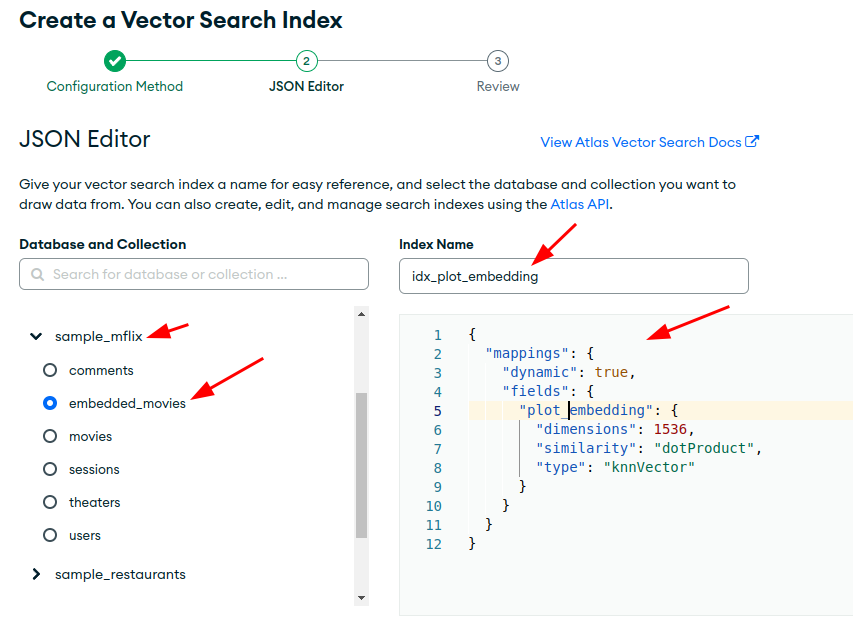



In [18]:
%%time

## Create a search index

INDEX_NAME = 'idx_plot_embedding'

collection.create_search_index(
    {"definition":
        {"mappings": {"dynamic": True, "fields": {
            'plot_embedding' : {
                "dimensions": 1536,
                "similarity": "dotProduct",
                "type": "knnVector"
                }}}},
     "name": INDEX_NAME
    }
)

OperationFailure: command not found, full error: {'ok': 0, 'errmsg': 'command not found', 'code': 59, 'codeName': 'CommandNotFound'}

## Do an Embedding Search

In [ ]:

def vector_search(query, limit=5):
  results = collection.aggregate([
    {
        '$vectorSearch': {
            "index": INDEX_NAME,
            "path": 'plot_embedding',
            "queryVector": get_embedding(query),
            "numCandidates": 50,
            "limit": limit,
        }
    }
    ])
  return results

In [ ]:
query="imaginary characters from outerspace at war with earthlings"
movies = list(vector_search(query, 5))
print (f"Found {len (movies)} movies")
for idx, movie in enumerate (movies):
    print(f'{idx+1}: title: {movie["title"]},\nplot: {movie["plot"]}\n')

In [ ]:
## Close connection

# mongodb_client.close()